# Project - Second Requirement

### Include packages.

In [13]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from scipy.stats import norm
from itertools import product
from scipy.optimize import linprog
from collections import Counter

### The first thing to do is to code the environment.

In [14]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

### In this setting, the environment is responsible for telling the seller about the reward.

In [15]:
class PricingEnvironmentMultiProduct(Environment):
    def __init__(self, costs, mean_valuations, std_valuations, buyers_per_round):
        self.N = len(costs)
        self.costs = np.array(costs)
        self.mean_valuations = np.array(mean_valuations)
        self.std_valuations = np.array(std_valuations)
        self.buyers_per_round = buyers_per_round

    def round(self, prices):
        sales_per_product = np.zeros(self.N)
        rewards_per_product = np.zeros(self.N)

        for i in range(self.N):
            p_t = prices[i]
            prob_buy = 1 - norm.cdf(p_t, loc=self.mean_valuations[i], scale=self.std_valuations[i])
            num_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)
            reward_i = (p_t - self.costs[i]) * num_sales

            sales_per_product[i] = num_sales
            rewards_per_product[i] = reward_i

        total_reward = np.sum(rewards_per_product)
        total_sales = np.sum(sales_per_product)
        return sales_per_product, total_reward, rewards_per_product

### Now define the setting...

We assume there is a product "true value", at which around 50% people would buy. We call it so, because in gaussian hypothesis, it represents the peak value "most customers agree" on.

In [16]:
# --- Global Settings ---

N = 4                       # Number of products
T = 20000                   # Time horizon (number of rounds)
n_trials = 3                # Number of independent trials for averaging

# --- Pricing Grid and Product Info ---

price_step = 0.5

K = 5         # Number of price options (arms per product)

costs = np.array([2.00, 1.50, 0.50, 4.00])
values = np.array([3.00, 2.50, 1.50, 6.00])
std_valuations = np.array([1.0, 0.8, 0.5, 1.5])

assert len(costs) == len(values) == len(std_valuations) == N, "costs, values, std_valuations must all be of length N"
assert np.all(costs < values), "Each product's cost must be less than its corresponding value"

# --- Build per-product price grids ---
price_grids = []
for i in range(N):
    p_min = 0.5 * costs[i]
    p_max = values[i] * 2
    custom_prices = np.linspace(p_min, p_max, 5)
    price_grids.append(custom_prices)

# --- Market and Inventory Parameters ---

B = 120000 * N                          # Total inventory (shared among all products)

# --- Derived Buyer Generation per Round ---

buyers_per_round = 50                   # Number of buyers per round per product
assert buyers_per_round >= 1, "Must have at least one buyer per round"

# --- Other Parameters ---

zoom = 0.0005            # Zoom factor for plotting
s = 30                  # random seed

# --- Formatter for Millions in the plots---
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

### Expected demand and profit using theoretical expectations.

In [17]:
# --- Initialize matrices for expected demand/profit ---
expected_demand_matrix = []
expected_profit_matrix = []

for i in range(N):
    prices = price_grids[i]
    demands = []
    profits = []
    for p in prices:
        prob_buy = 1 - norm.cdf(p, loc=values[i], scale=std_valuations[i])
        expected_demand = buyers_per_round * prob_buy
        expected_profit = (p - costs[i]) * expected_demand
        demands.append(expected_demand)
        profits.append(expected_profit)
    expected_demand_matrix.append(demands)
    expected_profit_matrix.append(profits)

expected_demand_matrix = np.array(expected_demand_matrix)
expected_profit_matrix = np.array(expected_profit_matrix)

# --- Find best price per product ---
best_price_indices = np.argmax(expected_profit_matrix, axis=1)
best_super_arm = tuple(best_price_indices.tolist())  # Tuple, tipo (2, 1, 4, 0)
best_prices = np.array([price_grids[i][idx] for i, idx in enumerate(best_price_indices)])
best_profits = expected_profit_matrix[np.arange(N), best_price_indices]

# --- Summary ---
print("=== Best Expected Prices ===")
for i in range(N):
    print(f"Product {i}: optimal price = €{best_prices[i]:.2f}, expected profit = €{best_profits[i]:.2f}")
print()

print(f"Best super arm: {tuple(idx+1 for idx in best_super_arm)} with expected profit = €{np.sum(best_profits):.2f}")
print(f"Expected total demand: {np.sum(expected_demand_matrix[np.arange(N), best_price_indices]):.2f} units")

=== Best Expected Prices ===
Product 0: optimal price = €3.50, expected profit = €23.14
Product 1: optimal price = €2.88, expected profit = €21.97
Product 2: optimal price = €1.62, expected profit = €22.57
Product 3: optimal price = €7.00, expected profit = €37.87

Best super arm: (3, 3, 3, 3) with expected profit = €105.56
Expected total demand: 64.10 units


### Let us visualize our setting.

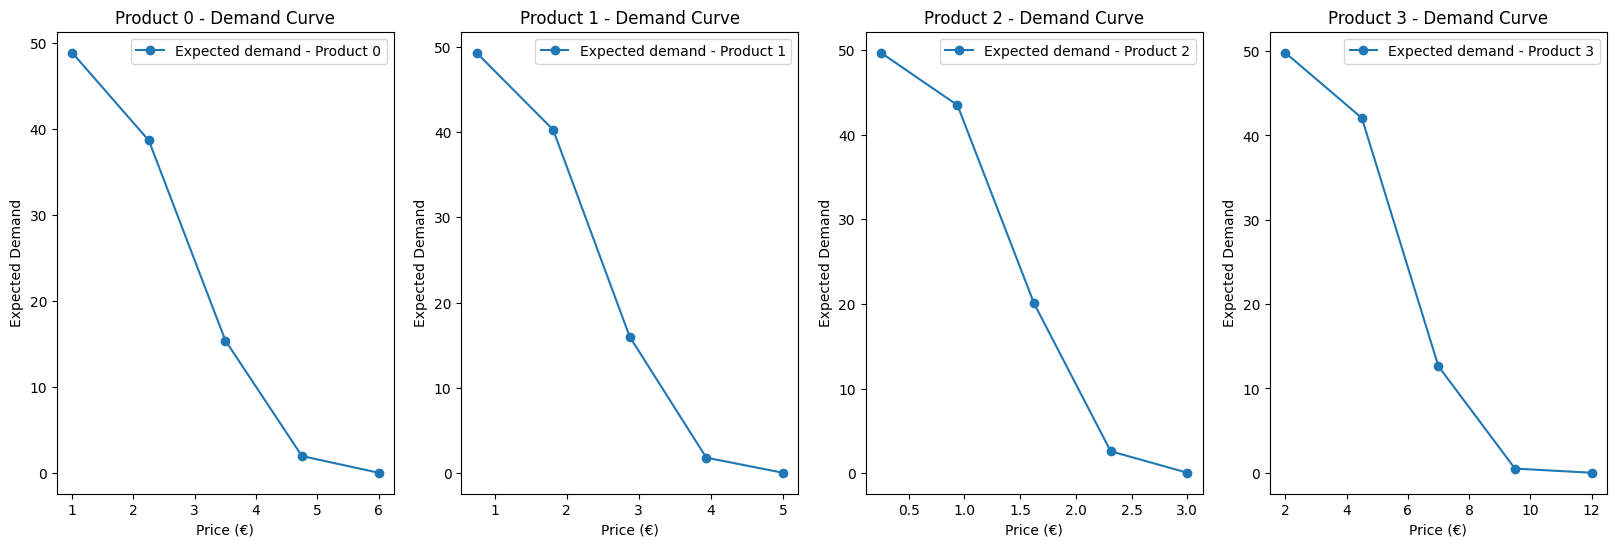

In [18]:
# --- Visualization ---

fig1, axs1 = plt.subplots(1, 4, figsize=(20, 6))

# Plot items
for i in range(min(N, 4)):
    axs1[i].plot(price_grids[i], expected_demand_matrix[i], label=f'Expected demand - Product {i}', marker='o')
    axs1[i].set_title(f"Product {i} - Demand Curve")
    axs1[i].set_xlabel("Price (€)")
    axs1[i].set_ylabel("Expected Demand")
    axs1[i].legend()

### Agent

In [ ]:
class GlobalLinearProgramUCB:
    def __init__(self, N, K, B, T, price_grids, scale=1.0):
        self.N = N
        self.K = K
        self.B = B
        self.T = T
        self.scale = scale
        self.price_grids = price_grids
        self.rho = B / T
        print(f"Using static rho = {B/T}")
        self.t = 0
        self.inventory = B

        # All possible actions = super-arms (as tuples of price indices)
        self.actions = list(product(range(K), repeat=N))
        self.A = len(self.actions)

        # To estimate rewards and consumption
        self.avg_rewards = np.zeros(self.A)
        self.avg_sales = np.zeros(self.A)
        self.N_pulls = np.zeros(self.A)

        self.last_action_idx = None

    def pull_arm(self):
        if self.inventory < 1:
            self.last_action_idx = None
            return None

        if self.t < self.A:
            action_idx = self.t
        else:
            ucb = self.avg_rewards + self.scale * np.sqrt(2 * np.log(self.T) / np.maximum(1, self.N_pulls))
            lcb = self.avg_sales - self.scale * np.sqrt(2 * np.log(self.T) / np.maximum(1, self.N_pulls))
            action_idx = self.solve_lp(ucb, lcb)

        self.last_action_idx = action_idx

        return self.actions[action_idx]

    def solve_lp(self, ucb_rewards, lcb_sales):
        # Solve: max sum(gamma[a] * ucb[a]) s.t. sum(gamma[a] * lcb[a]) <= rho, sum gamma = 1
        c = -ucb_rewards
        A_ub = [lcb_sales]
        b_ub = [self.rho]
        A_eq = [np.ones(self.A)]
        b_eq = [1]
        bounds = [(0, 1)] * self.A

        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
        if res.success:
            gamma = res.x
            return np.random.choice(self.A, p=gamma)
        else:
            return np.argmax(ucb_rewards)

    def update(self, sales, total_reward):
        if self.last_action_idx is None:
            return

        idx = self.last_action_idx
        self.N_pulls[idx] += 1
        self.avg_rewards[idx] += (total_reward - self.avg_rewards[idx]) / self.N_pulls[idx]
        self.avg_sales[idx] += (np.sum(sales) - self.avg_sales[idx]) / self.N_pulls[idx]
        self.inventory -= np.sum(sales)
        self.t += 1

### Run

We waste so many products in the exploration phase!

Using static rho = 24.0
Using static rho = 24.0
Using static rho = 24.0


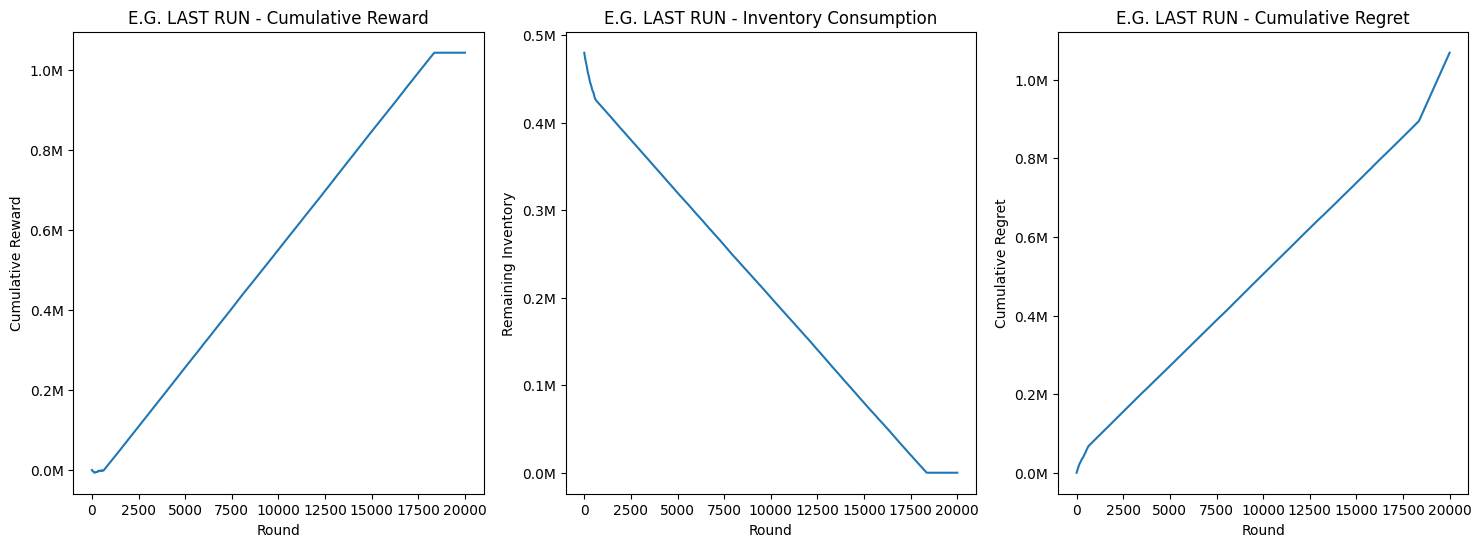

In [20]:
# --- Data storage for the last run (for original plots) ---

last_run_rewards_over_time = []
last_run_inventory_left = []

# --- Start of Cumulative Regret Computation Over Multiple Trials ---
regret_per_trial = []

# The expected clairvoyant reward per round is the sum of the best profits across all products
expected_clairvoyant_rewards_per_round = np.sum(best_profits)

for seed in range(n_trials):

    # Initialize the stochastic environment for each trial
    np.random.seed(seed)
    env = PricingEnvironmentMultiProduct( # Ensure this class is imported or defined
        costs=costs,
        mean_valuations=values,
        std_valuations=std_valuations,
        buyers_per_round=buyers_per_round
    )

    # Initialize the agent for each trial
    agent = GlobalLinearProgramUCB(N, K, B, T, price_grids, scale = 1) # Ensure this class is imported or define

    # To log instant regret for this specific trial
    regret_over_time_this_trial = []
    
    # Also log for the last run if this is the last trial
    current_run_rewards_over_time = []
    current_run_inventory_left = []
    current_run_actions = []

    # Run the agent for T rounds
    for t in range(T):

        a_t = agent.pull_arm()

        if seed == n_trials - 1 and a_t is not None:
            current_run_actions.append(tuple(a_t))  # Store action as tuple for counting

        if a_t is None:
            # If inventory runs out, the agent gets 0 reward for the rest of the rounds.
            # Regret becomes maximal.
            istant_regret = expected_clairvoyant_rewards_per_round
            regret_over_time_this_trial.append(istant_regret)
            
            # For logging inventory and reward for the last run
            current_run_rewards_over_time.append(0) # No reward when inventory is empty
            current_run_inventory_left.append(0) # Inventory is 0

            # Fill the remaining rounds with max regret, 0 reward, and 0 inventory
            for _ in range(T - t - 1):
                regret_over_time_this_trial.append(expected_clairvoyant_rewards_per_round)
                current_run_rewards_over_time.append(0)
                current_run_inventory_left.append(0)
            break

        prices = [price_grids[i][a_t[i]] for i in range(N)]
        sales, total_reward, rewards_per_product = env.round(prices)
        agent.update(sales, total_reward)

        # Calculate the instant regret
        istant_regret = expected_clairvoyant_rewards_per_round - total_reward
        regret_over_time_this_trial.append(istant_regret)
        
        # Log for the current run (potential last run)
        current_run_rewards_over_time.append(total_reward)
        current_run_inventory_left.append(agent.inventory)

    # Ensure regret_over_time_this_trial has exactly T elements
    while len(regret_over_time_this_trial) < T:
        regret_over_time_this_trial.append(expected_clairvoyant_rewards_per_round) # Add max regret if loop broke early

    # Ensure current_run_rewards_over_time and current_run_inventory_left have T elements
    while len(current_run_rewards_over_time) < T:
        current_run_rewards_over_time.append(0) # No reward
        current_run_inventory_left.append(0) # No inventory

    # Store cumulative regret for this trial
    cumulative_regret = np.cumsum(regret_over_time_this_trial)
    regret_per_trial.append(cumulative_regret)

    # If this is the last trial, store its data for plotting
    if seed == n_trials - 1:
        last_run_rewards_over_time = current_run_rewards_over_time
        last_run_inventory_left = current_run_inventory_left
        last_run_actions = current_run_actions


# --- To plot (from the last run) ---
cumulative_reward_last_run = np.cumsum(np.array(last_run_rewards_over_time))
cumulative_regret_last_run = np.cumsum(np.array(regret_over_time_this_trial))

# --- Plot ---
plt.figure(figsize=(18, 6)) # Adjusted figure size for 3 subplots in a row

# Subplot 1: Cumulative Reward
plt.subplot(1, 3, 1) # 1 row, 3 columns, first plot
plt.plot(cumulative_reward_last_run)
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.title("E.G. LAST RUN - Cumulative Reward")
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

# Subplot 2: Inventory Consumption
plt.subplot(1, 3, 2) # 1 row, 3 columns, second plot
plt.plot(last_run_inventory_left)
plt.xlabel("Round")
plt.ylabel("Remaining Inventory") # Clarified label
plt.title("E.G. LAST RUN - Inventory Consumption")
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

# Subplot 3: Cumulative Regret
plt.subplot(1, 3, 3) # 1 row, 3 columns, third plot
plt.plot(cumulative_regret_last_run)
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title("E.G. LAST RUN - Cumulative Regret")
# Apply custom formatter for the y-axis of cumulative regret
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

### Show most played arms

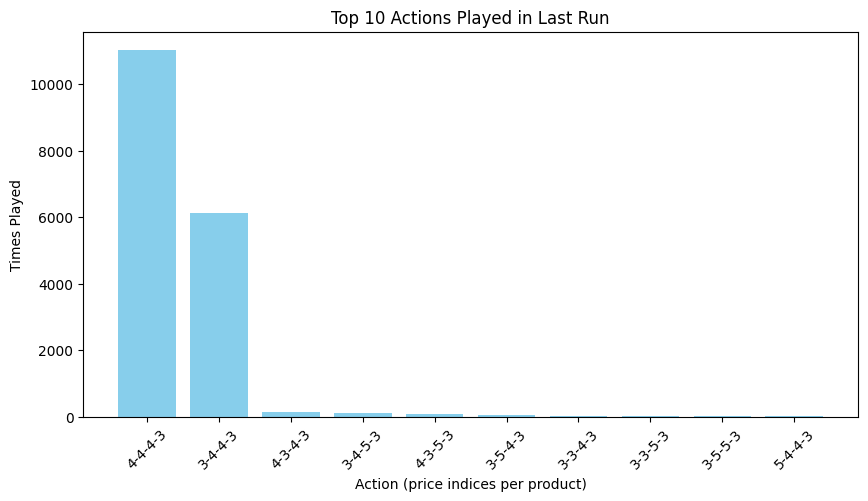

In [21]:
# Count how many times each action was played
action_counts = Counter(last_run_actions)
# Sort actions by frequency
most_common_actions = action_counts.most_common(10)  # Show top 10 actions
# Prepare labels and values
action_labels = action_labels = ['-'.join(str(i + 1) for i in action) for action, _ in most_common_actions]
action_freqs = [count for _, count in most_common_actions]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(action_labels, action_freqs, color='skyblue')
plt.xticks(rotation=45)
plt.xlabel("Action (price indices per product)")
plt.ylabel("Times Played")
_ = plt.title("Top 10 Actions Played in Last Run")

### Show regret

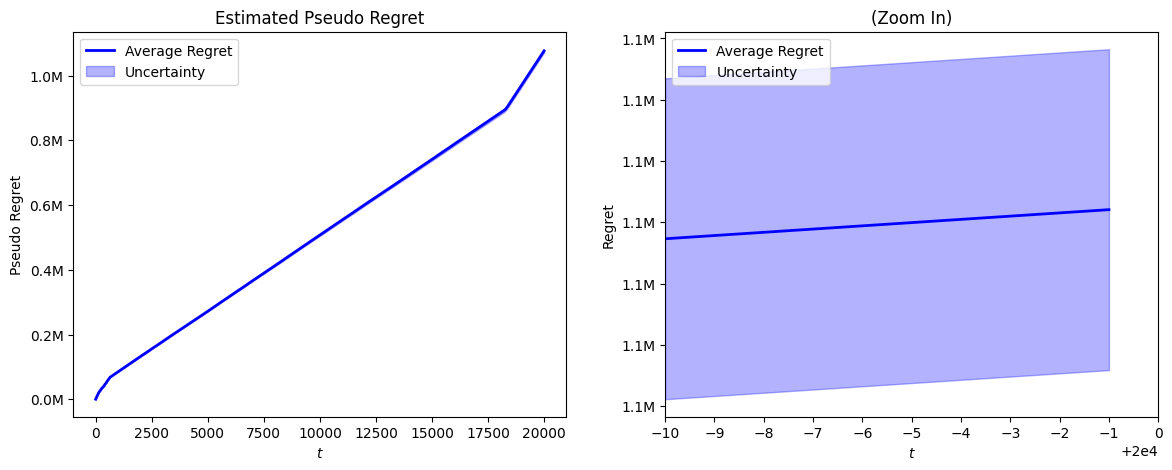

In [22]:
# Compute average (and standard deviation) of regret across all trials
average_regret = np.array(regret_per_trial).mean(axis=0)
regret_sd = np.array(regret_per_trial).std(axis=0)

# --- Plotting Average Cumulative Regret (Pseudo Regret) ---

# Set zoom start time based on the zoom factor
zoom_start_t = int(max(0, T - max(1, int(T * zoom))))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# Full Plot (left)
ax1.plot(np.arange(T), average_regret, 'b-', linewidth=2, label='Average Regret')
ax1.fill_between(np.arange(T), average_regret - regret_sd / np.sqrt(n_trials), average_regret + regret_sd / np.sqrt(n_trials), alpha=0.3, color='blue', label='Uncertainty')
ax1.set_title('Estimated Pseudo Regret')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Pseudo Regret')
ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

# Zoom In Plot (right)
ax2.plot(np.arange(zoom_start_t, T), average_regret[zoom_start_t:], 'b-', linewidth=2, label='Average Regret')
ax2.fill_between(np.arange(zoom_start_t, T), (average_regret - regret_sd / np.sqrt(n_trials))[zoom_start_t:], (average_regret + regret_sd / np.sqrt(n_trials))[zoom_start_t:], alpha=0.3, color='blue', label='Uncertainty')
ax2.set_xlim(zoom_start_t, T)
ax2.set_title('(Zoom In)')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Regret')
ax2.legend()
ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
_ = ax2.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

### Modified version

Here we make rho dynamic, to better spend the budget in a setting in which we waste many rounds to initialize the algorithm bounds.

In [ ]:
class GlobalLinearProgramUCB_Modified:
    def __init__(self, N, K, B, T, price_grids, scale=1.0):
        self.N = N
        self.K = K
        self.B = B
        self.T = T
        self.scale = scale
        self.price_grids = price_grids
        self.rho = B / T if T > 0 else 1e-8
        self.t = 0
        self.inventory = B

        # All possible actions = super-arms (as tuples of price indices)
        self.actions = list(product(range(K), repeat=N))
        self.A = len(self.actions)

        # To estimate rewards and consumption
        self.avg_rewards = np.zeros(self.A)
        self.avg_sales = np.zeros(self.A)
        self.N_pulls = np.zeros(self.A)

        self.last_action_idx = None

    def pull_arm(self):

        if self.inventory < 1:
            self.last_action_idx = None
            return None

        # Possibly handle the last round scenario
        if self.T - self.t <= 0:
            current_rho = 0
        # Calculate the remaining budget per round dynamically (rho)
        else:
            current_rho = self.inventory / ( self.T - self.t)

        # Init the bounds
        if self.t < self.A:
            action_idx = self.t
        else:
            ucb = self.avg_rewards + self.scale * np.sqrt(2 * np.log(self.T) / np.maximum(1, self.N_pulls))
            lcb = self.avg_sales - self.scale * np.sqrt(2 * np.log(self.T) / np.maximum(1, self.N_pulls))
            # Pass the dynamic budget to solve_lp
            action_idx = self.solve_lp(ucb, lcb, current_rho)

        # Store the last action index and return
        self.last_action_idx = action_idx
        return self.actions[action_idx]

    def solve_lp(self, ucb_rewards, lcb_sales, current_rho):
        # Solve: max sum(gamma[a] * ucb[a]) s.t. sum(gamma[a] * lcb[a]) <= rho, sum gamma = 1
        c = -ucb_rewards
        A_ub = [lcb_sales]
        b_ub = [current_rho]
        A_eq = [np.ones(self.A)]
        b_eq = [1]
        bounds = [(0, 1)] * self.A

        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
        if res.success:
            gamma = res.x
            return np.random.choice(self.A, p=gamma)
        else:
            return np.argmax(ucb_rewards)

    def update(self, sales, total_reward):
        if self.last_action_idx is None:
            return

        idx = self.last_action_idx
        self.N_pulls[idx] += 1
        self.avg_rewards[idx] += (total_reward - self.avg_rewards[idx]) / self.N_pulls[idx]
        self.avg_sales[idx] += (np.sum(sales) - self.avg_sales[idx]) / self.N_pulls[idx]
        self.inventory -= np.sum(sales)
        self.t += 1

### Run

In [24]:
# --- Start of Cumulative Regret Computation Over Multiple Trials ---
regret_per_trial = []

# The expected clairvoyant reward per round is the sum of the best profits across all products
expected_clairvoyant_rewards_per_round = np.sum(best_profits)

for seed in range(n_trials):

    # Initialize the stochastic environment for each trial
    np.random.seed(seed)
    env = PricingEnvironmentMultiProduct( # Ensure this class is imported or defined
        costs=costs,
        mean_valuations=values,
        std_valuations=std_valuations,
        buyers_per_round=buyers_per_round
    )

    # Initialize the agent for each trial
    agent = GlobalLinearProgramUCB_Modified(N, K, B, T, price_grids, scale = 1) # Ensure this class is imported or defined

    # To log instant regret for this specific trial
    regret_over_time_this_trial = []
    
    # Also log for the last run if this is the last trial
    current_run_rewards_over_time = []
    current_run_inventory_left = []

    # Run the agent for T rounds
    for t in range(T):

        a_t = agent.pull_arm()

        if a_t is None:
            # If inventory runs out, the agent gets 0 reward for the rest of the rounds.
            # Regret becomes maximal.
            istant_regret = expected_clairvoyant_rewards_per_round
            regret_over_time_this_trial.append(istant_regret)

            # To visualize the LCB of the best super arm
            lcb_consumption = agent.avg_sales[agent.actions.index(best_super_arm)] - agent.scale * np.sqrt(2 * np.log(agent.T) / agent.N_pulls[agent.actions.index(best_super_arm)])
            print(f"Round {t} | LCB consumption for best super-arm {tuple(idx+1 for idx in best_super_arm)} : {lcb_consumption:.2f}")
            
            # For logging inventory and reward for the last run
            current_run_rewards_over_time.append(0) # No reward when inventory is empty
            current_run_inventory_left.append(0) # Inventory is 0

            # Fill the remaining rounds with max regret, 0 reward, and 0 inventory
            for _ in range(T - t - 1):
                regret_over_time_this_trial.append(expected_clairvoyant_rewards_per_round)
                current_run_rewards_over_time.append(0)
                current_run_inventory_left.append(0)
            break

        prices = [price_grids[i][a_t[i]] for i in range(N)]
        sales, total_reward, rewards_per_product = env.round(prices)
        agent.update(sales, total_reward)

        # Calculate the instant regret
        istant_regret = expected_clairvoyant_rewards_per_round - total_reward
        regret_over_time_this_trial.append(istant_regret)
        
        # Log for the current run (potential last run)
        current_run_rewards_over_time.append(total_reward)
        current_run_inventory_left.append(agent.inventory)

    # Ensure regret_over_time_this_trial has exactly T elements
    while len(regret_over_time_this_trial) < T:
        regret_over_time_this_trial.append(expected_clairvoyant_rewards_per_round) # Add max regret if loop broke early

    # Ensure current_run_rewards_over_time and current_run_inventory_left have T elements
    while len(current_run_rewards_over_time) < T:
        current_run_rewards_over_time.append(0) # No reward
        current_run_inventory_left.append(0) # No inventory

    # Store cumulative regret for this trial
    cumulative_regret = np.cumsum(regret_over_time_this_trial)
    regret_per_trial.append(cumulative_regret)

### Show regret

Zoom start round: 19990


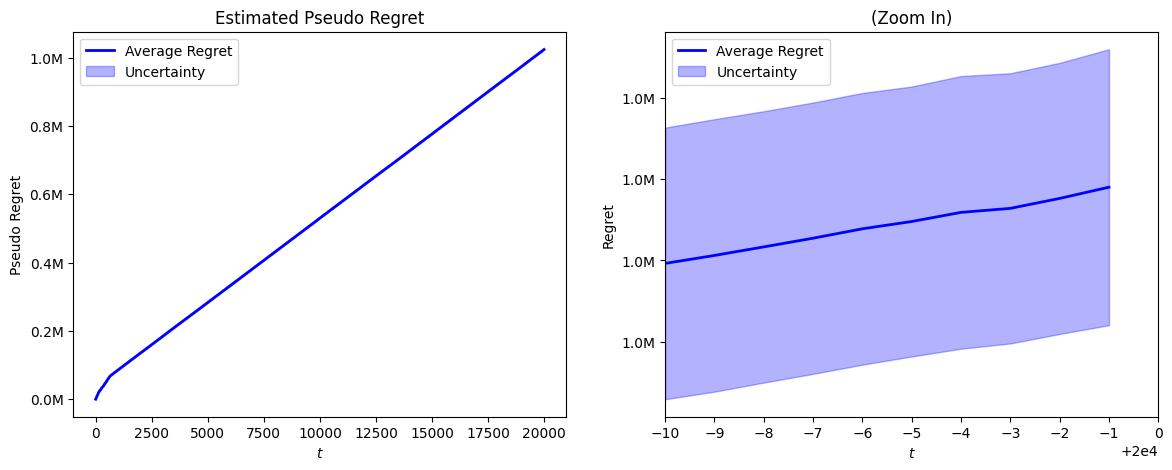

In [25]:
# Compute average (and standard deviation) of regret across all trials
average_regret = np.array(regret_per_trial).mean(axis=0)
regret_sd = np.array(regret_per_trial).std(axis=0)

# --- Plotting Average Cumulative Regret (Pseudo Regret) ---

# Set zoom start time based on the zoom factor
zoom_start_t = max(0, T - max(1, int(T * zoom)))
print(f"Zoom start round: {zoom_start_t}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# Full Plot (left)
ax1.plot(np.arange(T), average_regret, 'b-', linewidth=2, label='Average Regret')
ax1.fill_between(np.arange(T), average_regret - regret_sd / np.sqrt(n_trials), average_regret + regret_sd / np.sqrt(n_trials), alpha=0.3, color='blue', label='Uncertainty')
ax1.set_title('Estimated Pseudo Regret')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Pseudo Regret')
ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

# Zoom In Plot (right)
ax2.plot(np.arange(zoom_start_t, T), average_regret[zoom_start_t:], 'b-', linewidth=2, label='Average Regret')
ax2.fill_between(np.arange(zoom_start_t, T), (average_regret - regret_sd / np.sqrt(n_trials))[zoom_start_t:], (average_regret + regret_sd / np.sqrt(n_trials))[zoom_start_t:], alpha=0.3, color='blue', label='Uncertainty')
ax2.set_xlim(zoom_start_t, T)
ax2.set_title('(Zoom In)')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Regret')
ax2.legend()
ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
_ = ax2.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

### Also visualize top superarms

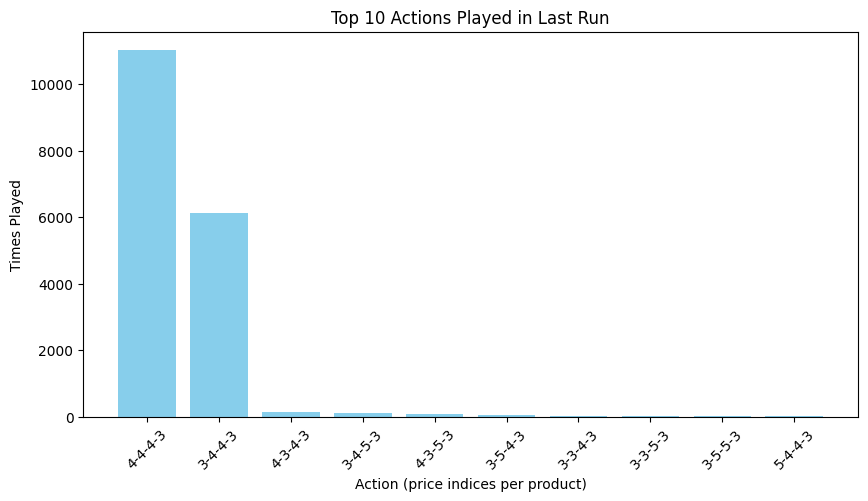

In [26]:
# Count how many times each action was played
action_counts = Counter(last_run_actions)
# Sort actions by frequency
most_common_actions = action_counts.most_common(10)  # Show top 10 actions
# Prepare labels and values
action_labels = action_labels = ['-'.join(str(i + 1) for i in action) for action, _ in most_common_actions]
action_freqs = [count for _, count in most_common_actions]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(action_labels, action_freqs, color='skyblue')
plt.xticks(rotation=45)
plt.xlabel("Action (price indices per product)")
plt.ylabel("Times Played")
_ = plt.title("Top 10 Actions Played in Last Run")